<a href="https://colab.research.google.com/github/csbanon/bert-product-rating-predictor/blob/master/Model_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Required modules
!pip install Unidecode
!pip install word2number

     |████████████████████████████████| 245kB 5.9MB/s 
  Created wheel for word2number: filename=word2number-1.1-cp36-none-any.whl size=5588 sha256=f4055731626386b7ae8c1d7be34fbd6dfc0a6a3bd4ebad65fb38cfaba7d7aaf1
  Stored in directory: /root/.cache/pip/wheels/46/2f/53/5f5c1d275492f2fce1cdab9a9bb12d49286dead829a4078e0e
Successfully built word2number


In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [ ]:
# More imports
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 

import string
import unidecode
import re
import unidecode

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# Create a dataframe of all reviews (with comments and star ratings only)
github_url = 'https://raw.githubusercontent.com/csbanon/bert-product-rating-predictor/master/data/reviews_comments_stars.csv'
df = pd.read_csv(github_url)
df = df[['comment', 'stars']]
df.head()

,comment,stars
0,I could sit here and write all about the specs...,5
1,A very reasonably priced laptop for basic comp...,4
2,"This is the best laptop deal you can get, full...",5
3,A few months after the purchase....It is still...,5
4,BUYER BE AWARE: This computer has Microsoft 10...,1


In [ ]:
# Tokenizer instantiation
tokenizer = RegexpTokenizer(r"\w+[a-zA-Z]")

In [ ]:
# Remove numeric characters
def remove_nums(text):
  text = re.sub("\d+", " ", text)
  return text

# Remove stop words
def remove_stopwords(text):
  stoplist = stopwords.words('english')
  not_stopwords = {'no', 'not'} # should not remove these if doing sentiment analysis
  stoplist = set([word for word in stoplist if word not in not_stopwords])
  words = [w for w in text if w not in stoplist]
  return words

# Lemmatization
lemmatizer = WordNetLemmatizer() 
def lemmatize(text):
  lem_text = [lemmatizer.lemmatize(i) for i in text]
  return lem_text

# Convert accented characters to ascii
def remove_accents(text):
  text = unidecode.unidecode(text)
  return text

def join_words(text):
  return ' '.join([word for word in text]).strip()

In [ ]:
# Perform preprocessing for all comments
df['comment'] = df['comment'].apply(lambda x: remove_accents(x))
df['comment'] = df['comment'].apply(lambda x: remove_nums(x))
df['comment'] = df['comment'].apply(lambda x: tokenizer.tokenize(x.lower())) # tokenizes and convert to lowercase
df['comment'] = df['comment'].apply(lambda x: remove_stopwords(x))
df['comment'] = df['comment'].apply(lambda x: lemmatize(x))
df['comment'] = df['comment'].apply(lambda x: join_words(x))

In [ ]:
df.head()

,comment,stars
0,could sit write spec computer already descript...,5
1,reasonably priced laptop basic computing need ...,4
2,best laptop deal get full stop touchescreen no...,5
3,month purchase still running good bought colle...,5
4,buyer aware computer microsoft scam software m...,1


## Train/Test Split
Split the dataset into training and testing sets.

In [ ]:
TEST_SIZE = 0.2

In [ ]:
train_dataset, test_dataset = train_test_split(df, test_size=TEST_SIZE, random_state=1)

train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

print("# of samples in train set: {}".format(len(train_dataset)))
print("# of samples in test set: {}".format(len(test_dataset)))

# of samples in train set: 156612
# of samples in test set: 39153


Initialize TF-IDF and Bag-of-Words vectorizers to generate vector representations of each review. 

In [ ]:
# For Multinomial Naive Bayes
tfidf_vectorizer = TfidfVectorizer(
    stop_words = 'english',
    max_features=5000
)

# Bag-of-words representation for Logistic Regression and Multinomial Naive Bayes
count_vectorizer = CountVectorizer(
    stop_words='english',
    max_features=5000
)

Define the function to plot the confusion matrix.

In [ ]:
def plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix'):
  cnf_matrix = confusion_matrix(y_test, y_pred, labels=[1,2,3,4,5])
  np.set_printoptions(precision=2)

  plt.figure()
  plot(cnf_matrix, classes=[1,2,3,4,5],
        title=title)

def plot(cm, classes,
        normalize=False,
        title='Confusion Matrix',
        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)
    print('\n', sep='')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Model Evaluation - Baselines

In [ ]:
y_train = train_dataset['stars']
y_test = test_dataset['stars']

### 1. Majority Class
Naive baseline that predicts all reviews to be of the majority class (5 stars).

In [ ]:
y_pred = np.full(shape=y_test.shape, fill_value=5, dtype=int)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000      3567
           2     0.0000    0.0000    0.0000      1821
           3     0.0000    0.0000    0.0000      2176
           4     0.0000    0.0000    0.0000      4508
           5     0.6917    1.0000    0.8177     27081

    accuracy                         0.6917     39153
   macro avg     0.1383    0.2000    0.1635     39153
weighted avg     0.4784    0.6917    0.5656     39153



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix
[[    0     0     0     0  3567]
 [    0     0     0     0  1821]
 [    0     0     0     0  2176]
 [    0     0     0     0  4508]
 [    0     0     0     0 27081]]




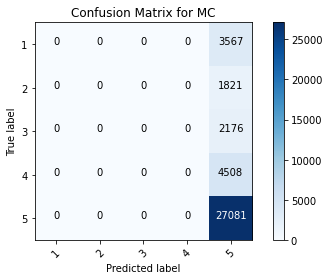

In [ ]:
plot_confusion_matrix(y_test, y_pred, 'Confusion Matrix for MC')

### 2. Multinomial Naive Bayes with BOW
Multinomial Naive Bayes using bag-of-words representation for sentence vectors.

In [ ]:
X_train = count_vectorizer.fit_transform(train_dataset['comment'])
X_test = count_vectorizer.fit_transform(test_dataset['comment'])

In [ ]:
mnb = MultinomialNB()
model = mnb.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           1     0.1286    0.0914    0.1069      3567
           2     0.0769    0.0588    0.0666      1821
           3     0.0905    0.2036    0.1253      2176
           4     0.1490    0.1493    0.1492      4508
           5     0.7372    0.7027    0.7195     27081

    accuracy                         0.5256     39153
   macro avg     0.2364    0.2411    0.2335     39153
weighted avg     0.5474    0.5256    0.5346     39153



Confusion matrix
[[  326   198   630   400  2013]
 [  135   107   385   267   927]
 [  135   115   443   286  1197]
 [  248   199   741   673  2647]
 [ 1691   773  2698  2890 19029]]




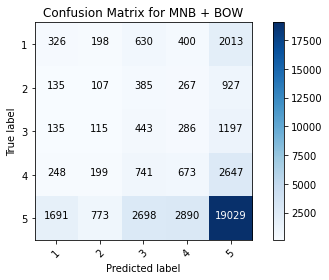

In [ ]:
plot_confusion_matrix(y_test, y_pred, 'Confusion Matrix for MNB + BOW')

### 3. Multinomial Naive Bayes with TF-IDF
Multinomial Naive Bayes using TF-IDF representation for sentence vectors.

In [ ]:
X_train = tfidf_vectorizer.fit_transform(train_dataset['comment'])
X_test = tfidf_vectorizer.fit_transform(test_dataset['comment'])

In [ ]:
mnb = MultinomialNB()
model = mnb.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           1     0.1654    0.0634    0.0916      3567
           2     0.0748    0.0242    0.0365      1821
           3     0.1088    0.0515    0.0699      2176
           4     0.1842    0.0419    0.0683      4508
           5     0.7082    0.9191    0.8000     27081

    accuracy                         0.6503     39153
   macro avg     0.2483    0.2200    0.2133     39153
weighted avg     0.5357    0.6503    0.5751     39153



Confusion matrix
[[  226    74   189    81  2997]
 [  105    44   100    80  1492]
 [   81    45   112    77  1861]
 [  150    97   168   189  3904]
 [  804   328   460   599 24890]]




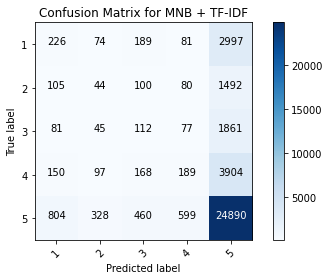

In [ ]:
plot_confusion_matrix(y_test, y_pred, 'Confusion Matrix for MNB + TF-IDF')

### 4. Logistic Regression with BOW
Logistic Regression using bag-of-words representation for sentence vectors.

In [ ]:
X_train = count_vectorizer.fit_transform(train_dataset['comment'])
X_test = count_vectorizer.fit_transform(test_dataset['comment'])

In [ ]:
lr = LogisticRegression(max_iter=1000)
model = lr.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           1     0.1068    0.1102    0.1085      3567
           2     0.0876    0.0308    0.0455      1821
           3     0.0904    0.0666    0.0767      2176
           4     0.1322    0.0739    0.0948      4508
           5     0.7120    0.8075    0.7567     27081

    accuracy                         0.5822     39153
   macro avg     0.2258    0.2178    0.2164     39153
weighted avg     0.5265    0.5822    0.5506     39153



Confusion matrix
[[  393    99   226   209  2640]
 [  226    56   128   164  1247]
 [  236    56   145   129  1610]
 [  499    92   235   333  3349]
 [ 2325   336   870  1683 21867]]




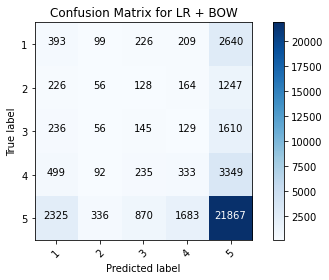

In [ ]:
plot_confusion_matrix(y_test, y_pred, 'Confusion Matrix for LR + BOW')

## Model Evaluation - BERT Variants

### 5. BERT (Regular)

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/csbanon/bert-product-rating-predictor/master/data/predictions_test.csv')

In [ ]:
y_pred = df['prediction'].tolist()
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           1     0.6903    0.7404    0.7145      3567
           2     0.3819    0.1812    0.2458      1821
           3     0.3679    0.4026    0.3845      2176
           4     0.5133    0.3305    0.4021      4508
           5     0.8925    0.9616    0.9258     27081

    accuracy                         0.8014     39153
   macro avg     0.5692    0.5233    0.5345     39153
weighted avg     0.7775    0.8014    0.7845     39153



Confusion matrix
[[ 2641   314   352    75   185]
 [  658   330   577   139   117]
 [  288   184   876   479   349]
 [  104    24   404  1490  2486]
 [  135    12   172   720 26042]]




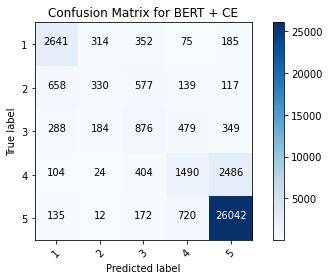

In [ ]:
plot_confusion_matrix(y_test, y_pred, 'Confusion Matrix for BERT + CE')

### 6. BERT with Weighted Cross Entropy Loss

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/csbanon/bert-product-rating-predictor/master/data/predictions_test_weighted.csv')

In [ ]:
y_pred = df['prediction'].tolist()
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           1     0.6921    0.7171    0.7044      3567
           2     0.3457    0.3427    0.3442      1821
           3     0.2802    0.5579    0.3730      2176
           4     0.2990    0.4583    0.3619      4508
           5     0.9470    0.7837    0.8577     27081

    accuracy                         0.7071     39153
   macro avg     0.5128    0.5719    0.5282     39153
weighted avg     0.7842    0.7071    0.7358     39153



Confusion matrix
[[ 2558   574   354    27    54]
 [  599   624   532    30    36]
 [  245   414  1214   212    91]
 [   98   119  1219  2066  1006]
 [  196    74  1014  4574 21223]]




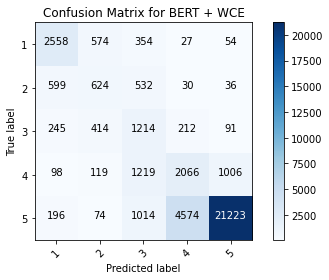

In [ ]:
plot_confusion_matrix(y_test, y_pred, 'Confusion Matrix for BERT + WCE')